# IMRT fluence maps and the power of transfer learning

The goal of this notebook is to predict gamma index values of calculated fluence maps in IMRT.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import random

print(f"pytorch version = {torch.__version__}")
print(f"torchvision version = {torchvision.__version__}")

pytorch version = 1.6.0
torchvision version = 0.7.0


In [2]:
import cv2
import matplotlib.pyplot as plt
import fastai as fa
from fastai.data.all import *
from fastai.vision.all import *

print(f"fast.ai version = {fa.__version__}")

fast.ai version = 2.0.0


## Data

Fluence maps are read from JPEG files, which are generated from DICOM files in RT Dose format, using __fluence_maps/util/dicom2jpeg.py__

In [3]:
SEED=12345
np.random.seed(SEED)
PATH = Path("/home/pablo/datasets/data/radioterapia/ciolaplata/")

# CODEX_FILE = "codex.2018-2019.csv" # mapas 3mm/3% con doseshift años 2018 y 2019
CODEX_FILE = "codex-2019-3mm3%-doseshift.csv" # mapas 3mm/3% con doseshift año 2019
# CODEX_FILE = "codex-2019-2mm2%-doseshift.csv" # mapas 2mm/2% con doseshift año 2019

MAPS_LOCATION_SUFFIX = "-opencv-jpeg"
path = PATH/Path("2018" + MAPS_LOCATION_SUFFIX)
path2 = PATH/Path("2019" + MAPS_LOCATION_SUFFIX)

# list_all = list(path.iterdir())+list(path2.iterdir())
list_all = list(path2.iterdir())
random.shuffle(list_all)
list_all[:10]

[Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.216485051912704638734202497383468742579.jpeg'),
 Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.193310708912086462001089916604076671693.jpeg'),
 Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.274774334211985898325767786691184357658.jpeg'),
 Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.350399622511682502805947189072436696506.jpeg'),
 Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.80879782311390246613429930583975303044.jpeg'),
 Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.101038118512805737413329783202511540406.jpeg'),
 Path('/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.52375772111590239742

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return im

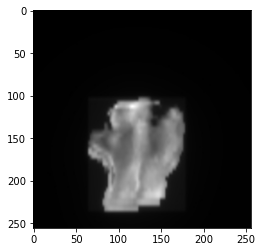

In [5]:
path = PATH/Path("2018" + MAPS_LOCATION_SUFFIX)/"1.3.6.1.4.1.9590.100.1.2.310116611339769406079254153056253359.jpeg"
im = read_image(path)
plt.imshow(im)

In [6]:
im = cv2.imread(str(path))
im.shape

(256, 256, 3)

In [7]:
# let's look at the typical size of these images
files = list_all[:1000]
dims = [read_image(str(p)).shape for p in files]

In [8]:
np.unique(dims)

array([  3, 256])

Amazing! all images have the same size.

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification task

Pablo:
1. Data augmentation can be enabled when creating the dataset, ex.: train_ds = FluenceMapsDataset(train_maps, transform=TRANSFORM)
2. Data augmentation did not improve MAE in validation. As with no data augmentation, overfitting is very small when data augmentation is used, but the problem is not overfitting but underfitting, i.e. performance in training is not good.

In [9]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

(240, 240, 3)

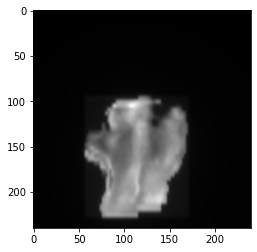

In [10]:
path = PATH/Path("2018" + MAPS_LOCATION_SUFFIX)/"1.3.6.1.4.1.9590.100.1.2.310116611339769406079254153056253359.jpeg"
im = read_image(path)
im_c = center_crop(im)
plt.imshow(im_c) # plt.imshow(im_c, cmap='gray') is the same
im_c.shape

### Resize, horizontal and vertical translations

(256, 256, 3)

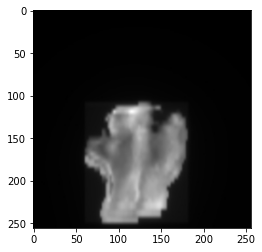

In [11]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
# Pablo: but I am not resizing to a larger size but to original size 256x256
im_l = cv2.resize(im, (272, 272))
im_l = random_crop(im_l)
plt.imshow(im_l)
im_l.shape

### Translation

In [12]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/
# py_geometric_transformations.html
def random_translation(x, t_pix=8):
    """ Returns a random translation"""
    rows, cols, *_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    t_r = np.floor(rand_r*t_pix).astype(int)
    t_c = np.floor(rand_c*t_pix).astype(int)
    # shift (t_r, t_c)
    T = np.float32([[1, 0, t_r], [0, 1, t_c]]) 
    # We use warpAffine to transform the image using the matrix T 
    return cv2.warpAffine(x, T, (cols, rows)), T

[[1. 0. 5.]
 [0. 1. 3.]]


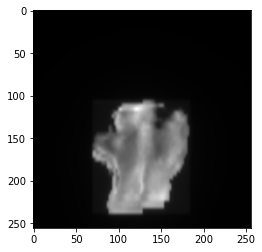

In [13]:
im_translation, T = random_translation(im)
print(T)
plt.imshow(im_translation) 

### Random Rotation (-10, 10) 

8.592321856342958


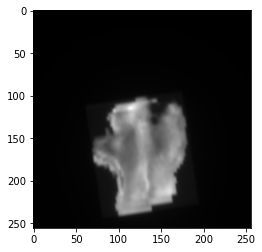

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

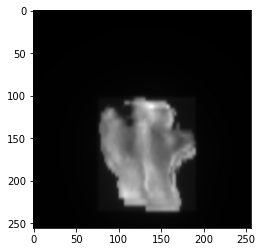

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Split train and validation

_Pablo: Not all fluence map files have a gamma value in the gamma .csv file, so we need to split the gamma .csv file and not the map files in the file system._

In [16]:
# from sklearn.model_selection import train_test_split
# all_files = list(PATH.iterdir())
# X_train, X_test = train_test_split(all_files, test_size=0.2, random_state=12345)

In [17]:
# print(len(X_train), len(X_test))

In [18]:
maps_in = pd.read_csv(PATH/CODEX_FILE, sep=';', delimiter=None, header=0)
maps_in.head()

,año,fluencia medida,fluencia calculada,uno menos gamma index
0,2019,1.3.6.1.4.1.9590.100.1.2.106363004312018285639264237160955287698,1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340,0.126820
1,2019,1.3.6.1.4.1.9590.100.1.2.117111588412865729801177307310520527927,1.3.6.1.4.1.9590.100.1.2.189485955411711008602298833212808936348,0.004941
2,2019,1.3.6.1.4.1.9590.100.1.2.190727149413805451333206478261481414648,1.3.6.1.4.1.9590.100.1.2.266447459412025533907550130074057505168,0.541950
3,2019,1.3.6.1.4.1.9590.100.1.2.211756715011326913522973909883744936800,1.3.6.1.4.1.9590.100.1.2.310552899912770926928572980550460292364,0.000000
4,2019,1.3.6.1.4.1.9590.100.1.2.225990696211768600614109735753330260661,1.3.6.1.4.1.9590.100.1.2.384142289612482598518084658210846605065,0.406440


In [19]:
maps_out = pd.DataFrame(columns=['relative_filename_jpeg', 'gamma_index'])
maps_out['relative_filename_jpeg'] = [Path(str(row[0])+MAPS_LOCATION_SUFFIX)/Path(str(row[1])+'.jpeg') for row in maps_in[['año', 'fluencia calculada']].values]
maps_out['gamma_index'] = maps_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)
maps_out.head()

,relative_filename_jpeg,gamma_index
0,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg,99.873180
1,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.189485955411711008602298833212808936348.jpeg,99.995059
2,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.266447459412025533907550130074057505168.jpeg,99.458050
3,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.310552899912770926928572980550460292364.jpeg,100.000000
4,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.384142289612482598518084658210846605065.jpeg,99.593560


In [20]:
maps_out['relative_filename_jpeg'][0], maps_out['gamma_index'][0]

(Path('2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.87318)

In [21]:
row = maps_out.iloc[0,:]
row['relative_filename_jpeg'], row['gamma_index'] 

(Path('2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.87318)

In [22]:
y = row['gamma_index']
y, type(y), y[None], type(y[None]), y[None][0], type(y[None][0])

(99.87318,
 numpy.float64,
 array([99.87318]),
 numpy.ndarray,
 99.87318,
 numpy.float64)

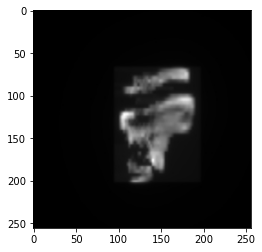

In [23]:
path = PATH/row['relative_filename_jpeg']
im = read_image(path)
plt.imshow(im)

In [24]:
im.shape

(256, 256, 3)

In [25]:
# channel 0
np.min(im[:,:,0]), np.max(im[:,:,0])

(0, 255)

In [26]:
mask = np.random.random(len(maps_out)) < 0.8
train_maps = maps_out[mask].copy()
valid_maps = maps_out[~mask].copy()

In [27]:
len(maps_out), len(train_maps), len(valid_maps) 

(1227, 972, 255)

In [28]:
files = [x for x in maps_out['relative_filename_jpeg']]
files = list(set(files)) # set(.) to remove duplicates
len(files)

1226

## Resizing data

In [29]:
# 272 = 256 (orig size) + 8*2 (8 pixels cropped)
def resize_crop_image(path, sz=(272, 272)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

In [30]:
def resize_all_images(resize_path):
    files = [x for x in train_maps['full_filename_jpeg']]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [31]:
TRANSFORM = False
# Uncomment to do random cropping as part of data augmentation
#
#if TRANSFORM:
#    RESIZE_PATH = 'train_272_272'
#    # just run the first time
#    resize_all_images(PATH/RESIZE_PATH)
#
#    train_maps['full_filename_jpeg'] = Path('/').joinpath(*(file.parts[:-2]+(RESIZE_PATH,)+(file.parts[-1],)))
#    train_maps.head()

## Dataset

In [32]:
train_maps['relative_filename_jpeg'][0], train_maps['gamma_index'][0]

(Path('2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg'),
 99.87318)

In [33]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    """
    # Image must be casted to float32 first
    image = image.astype('float')
    image = (image/255.0)
    return image

In [34]:
def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    """
    # Image must be casted to float32 first
    image = image.astype('float')
    # Rescale image from [0, 255] to [0, 2], and by substracting -1 we rescale to [-1, 1].
    image = (image/127.5) - 1
    return image

In [35]:
def fastai_rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    """
    timage = TensorImage(image2tensor(x))
    tfm = IntToFloatTensor()
    timage = tfm(timage)
    return timage

In [36]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    imagenet_stats = np.array([mean, std])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [37]:
class FluenceMapsDataset(Dataset):
    def __init__(self, path, maps, transform=False):
        self.path = path
        self.num_maps = len(maps)
        self.maps = maps
        self.transform = transform
        
    def __len__(self):
        return self.num_maps
    
    def __getitem__(self, index):
        row = self.maps.iloc[index,:]
        y = row['gamma_index']
        path = str(self.path/row['relative_filename_jpeg'])
        x = read_image(path)
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            # x = random_crop(x)
            # if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x, _ = random_translation(x)
        x = rescale_0_to_1(x)
        # x = normalize(x) # do not normalize, model performance is lower.
        # rollaxis: (256, 256, 3) => (3, 256, 256)
        return np.rollaxis(x, 2), y[None], path # y[None] converts y to numpy.ndarray 

In [38]:
train_ds = FluenceMapsDataset(PATH, train_maps, transform=TRANSFORM)
valid_ds = FluenceMapsDataset(PATH, valid_maps)

In [39]:
x, y, f = train_ds[0]
x.shape, y, f

((3, 256, 256),
 array([99.87318]),
 '/home/pablo/datasets/data/radioterapia/ciolaplata/2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.250681179813913418312485712811639382340.jpeg')

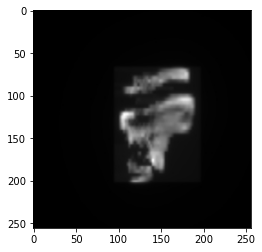

In [40]:
row = train_maps.iloc[0,:]
path = PATH/row['relative_filename_jpeg']
im = read_image(path)
plt.imshow(im)

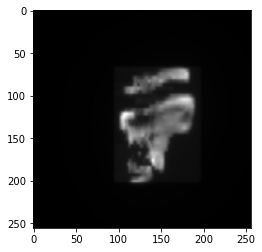

In [41]:
x = np.rollaxis(x, 2)
x = np.rollaxis(x, 2)
plt.imshow(x)

In [42]:
x, y, _ = valid_ds[0]
x.shape, y

((3, 256, 256), array([100.]))

In [43]:
BATCH_SIZE = 32

In [44]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=8)

In [45]:
len(train_ds)

972

In [46]:
len(train_loader)

31

In [47]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

## fastai2 DataLoader

In [114]:
# https://docs.fast.ai/vision.data#ImageDataLoaders.from_df
# dls = ImageDataLoaders.from_df(maps_out, path=PATH, fn_col=0, label_col=1, y_block=RegressionBlock,
#                                bs=BATCH_SIZE, item_tfms=[IntToFloatTensor()],
#                                seed=SEED, valid_pct=0.2, shuffle_train=True)

# https://github.com/fastai/course-v4/blob/master/nbs/06_multicat.ipynb
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x = lambda r: PATH/r['relative_filename_jpeg'], # need to specify full path
                   get_y = lambda r: r['gamma_index'],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

# dsets = dblock.datasets(maps_out)
# dsets.train[0]

dls = dblock.dataloaders(maps_out, batch_size=BATCH_SIZE, num_workers=8, shuffle_train=True, verbose=True)

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


In [115]:
test_eq(len(dls.one_batch()[0]), BATCH_SIZE)

In [116]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(982, 245)

In [117]:
dls.train_ds.items[:5]

,relative_filename_jpeg,gamma_index
158,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.210894710213393984308348451023739183015.jpeg,99.905765
137,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.307107771211012512800844901450965016354.jpeg,98.498700
733,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.215022383213499892610063845704227201633.jpeg,99.601020
534,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.227800304111253307328844965161085541084.jpeg,99.876110
803,2019-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.75175232911819172302780261722287707754.jpeg,99.972170


In [118]:
x, y = dls.train_ds[1]
type(x), type(y)

(fastai.vision.core.PILImage, torch.Tensor)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0760d97b90>, (256, 256))

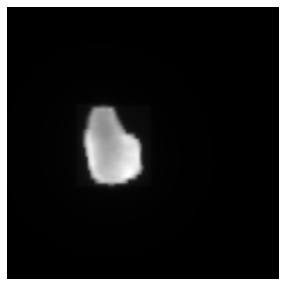

In [119]:
x.show(), x.shape

In [120]:
batch = dls.one_batch()
batch[0].shape, type(batch[0])

(torch.Size([32, 3, 256, 256]), fastai.torch_core.TensorImage)

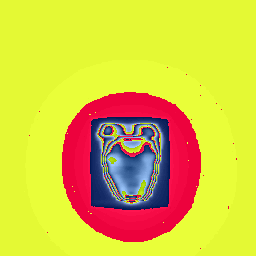

In [121]:
to_image(batch[0][0])

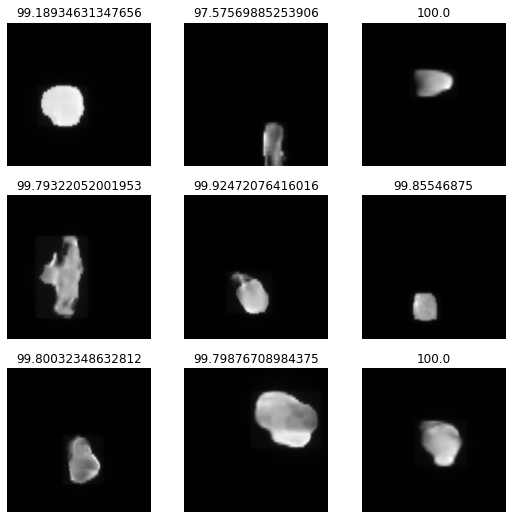

In [122]:
dls.show_batch(max_n=9)

## fastai2 Learner

In [137]:
learn = cnn_learner(dls, models.resnet18, loss_func=L1LossFlat())

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=0.0831763744354248)

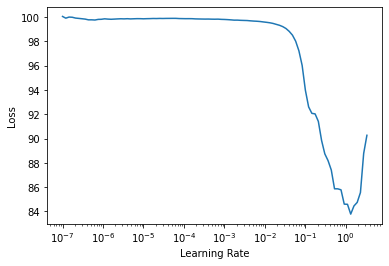

In [138]:
learn.lr_find()

## Training frozen model and fine-tuning

In [140]:
# https://docs.fast.ai/callback.schedule.html
learn.fine_tune(200, base_lr=2e-2, freeze_epochs=10)

epoch,train_loss,valid_loss,time
0,99.348572,100.169609,00:02
1,98.621559,97.876900,00:02
2,95.860016,88.227921,00:02
3,79.819016,28.370010,00:02
4,48.821507,24.477417,00:02
5,31.072535,7.221565,00:02
6,20.444407,5.199683,00:02
7,14.253314,3.826603,00:02
8,10.352068,2.772504,00:02
9,8.095754,3.452002,00:02


epoch,train_loss,valid_loss,time
0,5.160256,2.386093,00:02
1,4.723403,1.501614,00:02
2,4.667306,2.737612,00:02
3,4.563388,1.502158,00:02
4,4.585774,1.206587,00:02
5,4.515943,1.187191,00:02
6,4.455287,0.976963,00:02
7,4.406381,0.968117,00:02
8,4.436558,1.108417,00:02
9,4.400185,1.161910,00:02


## Stage-1: Training frozen model

In [130]:
lr1 = 0.01
learn.fit_one_cycle(10, lr1)
learn.save('stage-1')

epoch,train_loss,valid_loss,time
0,99.409348,98.528183,00:02
1,95.331436,85.333290,00:02
2,60.272186,17.535383,00:02
3,35.177910,16.329445,00:02
4,21.829142,7.672772,00:02
5,14.693480,3.609566,00:02
6,10.772880,3.711006,00:02
7,8.779972,2.789562,00:02
8,7.526001,1.524376,00:02
9,6.674037,1.378623,00:02


Path('models/stage-1.pth')

In [266]:
learn.load('stage-1')

## Stage-2: Fine-tuning complete model

In [131]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=1.9054607491852948e-06)

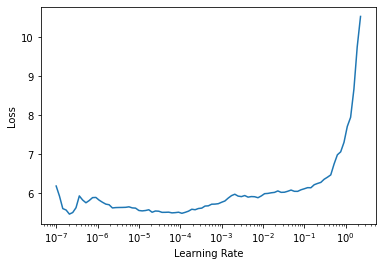

In [132]:
learn.lr_find()

In [133]:
lr2 = lr1/10
learn.fit_one_cycle(50, lr_max=slice(1e-5, lr2))
learn.save('stage-2')

epoch,train_loss,valid_loss,time
0,5.770039,1.160457,00:02
1,5.608994,1.267490,00:02
2,5.719985,1.436402,00:02
3,5.644812,1.192002,00:02
4,5.746238,1.390125,00:02
5,5.640454,1.765674,00:02
6,5.602775,2.337129,00:02
7,5.603944,1.647715,00:02
8,5.664678,1.560545,00:02
9,5.700264,2.356560,00:02


Path('models/stage-2.pth')

## Model

In [50]:
#conda install ipywidgets
resnet = models.resnet18(pretrained=True)
#resnet = models.resnet34(pretrained=True)
#resnet 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/pablo/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [51]:
layers = list(resnet.children())
print(len(layers))
# layers[-2:]
for i in range(len(layers)):
    print (f"-----------------------layer {i}-----------------------")
    print(layers[i])
    
# we want to freeze the fc2 layer this time: only train fc1 and fc3
#net.fc2.weight.requires_grad = False
#net.fc2.bias.requires_grad = False

#for param in resnet.parameters():
#    param.requires_grad = True
    
#layers[0].weight.requires_grad = False
#layers[1].requires_grad = False
#layers[4][0].conv1.weight.requires_grad = False
#layers[4][0].conv2.weight.requires_grad = False

#for param in resnet.parameters():
#    print(param.shape, param.requires_grad)

10
-----------------------layer 0-----------------------
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-----------------------layer 1-----------------------
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-----------------------layer 2-----------------------
ReLU(inplace=True)
-----------------------layer 3-----------------------
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-----------------------layer 4-----------------------
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64,

In [52]:
# see https://discuss.pytorch.org/t/pytorch-equivalent-of-keras/29412
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        #resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.out = 512 + 512
        self.bn1 = nn.BatchNorm1d(self.out)
        self.fc1 = nn.Linear(self.out, 512)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x1 = nn.AdaptiveAvgPool2d((1,1))(x)
        x1 = x1.view(x1.shape[0], -1) # flattening
        x2 = nn.AdaptiveMaxPool2d((1,1))(x)
        x2 = x2.view(x2.shape[0], -1) # flattening
        x = torch.cat([x1, x2], 1)
        x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = self.classifier(x)
        return x

In [53]:
model = Net().cuda()

In [54]:
model

Net(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [55]:
x, y, _ = next(iter(train_dl))

In [56]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([32, 3, 256, 256])

In [57]:
x_features = model.features1(x)
x_features.shape

torch.Size([32, 128, 32, 32])

In [58]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([32, 512, 8, 8])

In [59]:
x_features2 = F.relu(x_features2)

In [60]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([32, 512, 1, 1])

In [61]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([32, 512])

In [62]:
y_hat = model(x)
y_hat.shape

torch.Size([32, 1])

In [63]:
# L1Loss (MAE), see https://pytorch.org/docs/master/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
F.l1_loss(y_hat, y)

tensor(99.6841, device='cuda:0', grad_fn=<L1LossBackward>)

In [64]:
y.shape

torch.Size([32, 1])

In [65]:
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False
#    
#for param in model.parameters():
#    print(param.requires_grad)

## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

## Learning rate finder

From this paper https://arxiv.org/pdf/1506.01186.pdf. This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from 1e-5 to 0.012.

In [66]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    #for param in model.parameters():
    #    print(param.requires_grad)
    return optim.Adam(params, weight_decay=1e-4)
    #return optim.Adam(params, weight_decay=0)
    #return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), weight_decay=1e-5)

    
def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [67]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))


def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=3):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    print(f"train size: {len(train_dl)}, no. iter: {iterations}, lr_high - lr_low: {lr_high - lr_low}, delta: {delta:.3e}")
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y, _ in train_dl:
            lr = lrs[ind]
            # print(f"lr: {lr}")
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses    

In [68]:
# >>> create model >>>
model = Net().cuda()
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False

lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.4)

train size: 31, no. iter: 93, lr_high - lr_low: 0.39999, delta: 4.301e-03


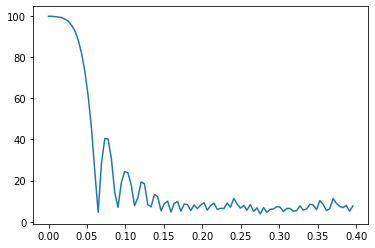

In [69]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [70]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    # print(f"i: {i}, c_i: {c_i}, res: {end_lr + (start_lr - end_lr)/2 *c_i}")
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    print(f"min_start: {min_start:.3e}, min_end: {min_end:.3e}, iter1: {iter1}, iter2: {iter2}")
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

min_start: 1.200e-03, min_end: 1.200e-07, iter1: 600, iter2: 1400


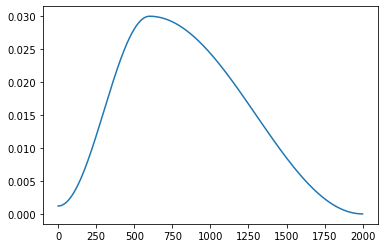

In [71]:
N = 2000
lr = get_cosine_triangular_lr(0.03, N)
plt.plot(list(range(N)), lr)
plt.show()

In [72]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y, _ in train_dl:
        lr = lrs[idx]
        # print(f"lr: {lr}")
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [73]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            if val_loss < 1.0: # only save model file if val MAE < 1.0
                path = "{0}/models/model_resnet18_{1:.3f}.pth".format(PATH, val_loss)
                save_model(model, path)
                print(path)

In [74]:
# changed for regression
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for x, y, _ in valid_dl:
            # x and y are tensors, x.shape is [64, 3, 256, 256] and y.shape is [64, 1]
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x) # out is a tensor with shape [64, 1]
            y = y.float()
            loss = F.l1_loss(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total

## Training with triangular rates

In [75]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [76]:
model = Net().cuda()

In [77]:
val_metrics(model, valid_dl)

98.73642228070428

In [78]:
MAX_LR = 0.02

In [79]:
# create models directory under /home/pablo/datasets/data/invasive-species-monitoring/ first time
# same for /home/pablo/datasets/data/radioterapia/ciolaplata/models/
model = Net().cuda()
# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = False
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 5)

min_start: 8.000e-04, min_end: 8.000e-08, iter1: 46, iter2: 109
train_loss 95.722 val_loss 73.025
train_loss 22.486 val_loss 894.528
train_loss 5.342 val_loss 5.938
train_loss 3.719 val_loss 3.270
train_loss 3.236 val_loss 3.093


In [80]:
model = Net().cuda()

# freeze parameters in layers 0 to 5
#for param in model.features1.parameters():
#    param.requires_grad = True

#for param in model.features2.parameters():
#    param.requires_grad = True
    
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 10)

min_start: 8.000e-04, min_end: 8.000e-08, iter1: 93, iter2: 217
train_loss 98.910 val_loss 90.956
train_loss 57.956 val_loss 146975.103
train_loss 8.115 val_loss 44.430
train_loss 4.025 val_loss 3.037
train_loss 2.883 val_loss 2.816
train_loss 2.105 val_loss 1.541
train_loss 1.654 val_loss 1.262
train_loss 1.447 val_loss 1.249
train_loss 1.273 val_loss 1.111
train_loss 1.285 val_loss 1.035


In [81]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 20)

min_start: 8.000e-04, min_end: 8.000e-08, iter1: 186, iter2: 434
train_loss 99.364 val_loss 97.290
train_loss 91.887 val_loss 83.961
train_loss 33.523 val_loss 2080.674
train_loss 6.417 val_loss 9.428
train_loss 3.983 val_loss 2.569
train_loss 2.959 val_loss 1.776
train_loss 2.167 val_loss 3.518
train_loss 1.797 val_loss 1.690
train_loss 1.383 val_loss 1.586
train_loss 1.110 val_loss 0.660
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.660.pth
train_loss 0.832 val_loss 0.551
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.551.pth
train_loss 0.782 val_loss 0.764
train_loss 0.585 val_loss 0.407
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.407.pth
train_loss 0.559 val_loss 0.529
train_loss 0.454 val_loss 0.599
train_loss 0.445 val_loss 0.347
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.347.pth
train_loss 0.354 val_loss 0.310
/home/pablo/datasets/data/radioterapia/ciolaplata/model

In [82]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=MAX_LR, epochs = 50)

min_start: 8.000e-04, min_end: 8.000e-08, iter1: 465, iter2: 1085
train_loss 99.528 val_loss 99.263
train_loss 97.722 val_loss 95.295
train_loss 89.464 val_loss 81.732
train_loss 58.115 val_loss 33.317
train_loss 9.332 val_loss 25.292
train_loss 5.033 val_loss 7.447
train_loss 4.209 val_loss 3.776
train_loss 3.627 val_loss 5.797
train_loss 3.164 val_loss 4.726
train_loss 2.514 val_loss 1.870
train_loss 2.048 val_loss 1.641
train_loss 1.732 val_loss 1.041
train_loss 1.319 val_loss 3.609
train_loss 1.184 val_loss 1.231
train_loss 1.358 val_loss 1.356
train_loss 0.818 val_loss 0.921
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.921.pth
train_loss 1.032 val_loss 0.813
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.813.pth
train_loss 1.006 val_loss 0.660
/home/pablo/datasets/data/radioterapia/ciolaplata/models/model_resnet18_0.660.pth
train_loss 1.128 val_loss 0.843
train_loss 1.272 val_loss 1.939
train_loss 1.219 val_loss 0.444
/home/p

## Load a model

In [83]:
def get_predictions_df(model, valid_dl):
    model.eval()
    pred = []
    with torch.no_grad():
        for x, y, file in valid_dl:
            # x and y are tensors, x.shape is [BATCH_SIZE, 3, 256, 256] and y.shape is [BATCH_SIZE, 1]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x) # out is a tensor with shape [BATCH_SIZE, 1]
            # a.cpu().numpy() == float(a.cpu().numpy())
            batch_pred = [(Path(f).name, a.cpu().item(), b.cpu().item()) for f, a, b in zip(file, y, out)]
            pred = pred + batch_pred
    # build a pandas dataframe with results
    df = pd.DataFrame(pred, columns=['filename', 'actual gamma', 'predicted gamma'])
    return df

In [84]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [85]:
# load model
mae = 0.217
model = Net().cuda()
p = PATH/"models/model_resnet18_{}.pth".format(mae)
load_model(model, p)

In [86]:
val_metrics(model, train_dl)

0.22347414150159545

In [87]:
val_metrics(model, valid_dl)

0.21766312537240048

In [90]:
part = "validation" # training or validation
if part == "validation":
    df = get_predictions_df(model, valid_dl)
else:
    df = get_predictions_df(model, train_dl)            
df.head()

,filename,actual gamma,predicted gamma
0,1.3.6.1.4.1.9590.100.1.2.314109839011190398406...,100.000000,99.905762
1,1.3.6.1.4.1.9590.100.1.2.121144172813816296236...,99.824692,99.954384
2,1.3.6.1.4.1.9590.100.1.2.255052206611700788638...,99.926895,99.811745
3,1.3.6.1.4.1.9590.100.1.2.302383480412871360932...,99.972778,99.774170
4,1.3.6.1.4.1.9590.100.1.2.818237160113817578140...,99.940521,99.871002


In [91]:
p = PATH/"predictions/model_resnet18_{}_{}.csv".format(mae, part)
df.to_csv(p, index=False)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions. This usually helps but here our accuracy is too high.

_Pablo: Since we are not doing data augmentation for fluence maps, then testing time augmentation neithe applies_

## Lab
Can you get better accuracy?
* Change some of the hyperparameters (add dropout, increase the number of the hidden units)
* Increase the image resolution
* Modify the data augmentation to include other transformations

# References
This notebook is based on https://github.com/yanneta/deep-learning-data-institute/blob/master/lesson5-image-cnn.ipynb from course "Fundamentals of Deep Learning with Pytorch"